# Redes Neuronales Convolucionales Desde Cero

En este notebook implementaremos una capa convolucional y una capa de agrupación desde cero, así como una función para aplicar las operaciones correspondientes, todo con el fin de entender mejor su funcionamiento.

Con esta finalidad, nos apoyaremos tanto en `numpy` como en `matplotlib`, dos de las librerías de Python más relevantes, populares y fundacionales para data science y machine learning.

## Preliminares

Empecemos importando las librerías que necesitaremos.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

Ahora configuremos algunos parámetros por defecto:

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## Nuestro Plan

Nuestro plan es implementar el siguiente modelo:

<img src="assets/model.png" style="width:800px;height:300px;">

Particularmente, implementaremos funciones para crear dos de las piezas más importantes de una CNN: **Capas convolucionales**, y **capas de agrupamiento**.

Dado que las redes neuronales propagan la información hacia adelante, y el error hacia atrás (para aprender), guardaremos algunos parámetros en un cache para evitar cálculos innecesarios.

## CNNs: Más Difíciles de lo que Parecen


TensorFlow, Keras, fast.ai, PyTorch, Caffe, Deeplearning4j... Estos son algunos de los frameworks que hacen que programar una red neuronal convolucional parezca fácil. Sin embargo, las CNNs siguen siendo uno de los conceptos más difíciles de entender en el campo de deep learning.

### Convolución

Esta es la operación principal de una capa de convolución. En resumen, transforma un volumen de entrada en un volumen de salida con un tamaño diferente: 

<img src="assets/conv_nn.png" style="width:350px;height:200px;">

### Padding

<img src="assets/PAD.png" style="width:600px;height:400px;">
<caption><center> Zero-Padding<br> Imagen (3 canales, RGB) con un padding de 2. </center></caption>

Padding consiste en adicionar ceros a los bordes de una imagen (o volumen) para permitir que las operaciones de convolución se lleven a cabo cerca de los límites del mismo. 

Esto tiene el beneficio de ayudarnos a mantener la información que aparece en los bordes de la imagen, la cual, sin padding, se perdería.

Así mismo, podemos aplicar convoluciones a volúmenes sin necesidad de reducir la altura o el peso de los volúmenes.

Implementemos una función para aplicar padding:

In [3]:
def zero_pad(X, pad):
    """
    :param X: X es un tensor de dimensiones (batch_size, height, width, number_of_channels).
    :param pad: Cantidad de padding a ser aplicado horizontal y verticalmente al volumen.
    
    :return El tensor X padded con ceros y con dimensiones (batch_size, height + 2 * pad, width + 2 * pad, number_of_channels)
    """
    
    # Aquí aplicamos padding 'constant' tanto al ancho como al alto. El primer y último [(0, 0)]  le indica a np.pad que queremos pad con ceros
    # cada batch y cada canal del volumen. La constante por defecto es cero, razón por la cual no lo especificamos de manera explícita.
    X_pad = np.pad(X, [(0, 0)] + [(pad, pad) for _ in range(len(X.shape[1:-1]))] + [(0, 0)], 'constant')

Probémosla.

In [4]:
np.random.seed(1)

X = np.random.randn(4, 3, 3, 2)
X_pad = zero_pad(X, 2)

print(f'X shape: {X.shape}')
print(f'X_pad shape: {X_pad.shape}')

X shape: (4, 3, 3, 2)
X_pad shape: (4, 7, 7, 2)


Mostremos X y X_pad como imágenes:

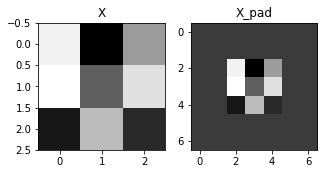

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title('X')
ax[0].imshow(X[0, :, :, 0])

ax[1].set_title('X_pad')
ax[1].imshow(X_pad[0, :, :, 0])

Podemos ver que `X_pad` tiene un borde negro que rodea a la imagen original correspondiente a `X`, lo cual tiene sentido, puesto que 0 representa el color negro absoluto en escala de grises.

### Paso de Convolución

Prosigamos con el paso principal: ¡Convolución!

Sólo como un recordatorio rápido, mira la imagen de abajo para refrescar tu mente sobre cómo una operación de convolución funciona:

<img src="assets/Convolution_schematic.gif" style="width:500px;height:300px;">
<caption><center> Convolución con un filtro 2x2 y un stride de 1 (stride = cantidad de pixeles que desplazaremos la ventana cada vez que la deslicemos por la imagen) </center></caption>

Aquí cada valor en la izquierda corresponde a un solo píxel, y estamos aplicando una convolución con un filtro 3x3. La operación, entonces, consiste en multiplicar la región de la imagen por los elementos en el filtro, posición por posición. Finalmente, sumamos todos los valores para producir una única entrada en el volumen resultante.

In [7]:
def convolution_step(previous_layer_slice, weights, bias):
    s = np.multiply(previous_layer_slice, weights)
    result = np.sum(s)
    result += bias[0, 0, 0]
    
    return Z

Probemos la función:

In [9]:
np.random.seed(1)

previous_layer_slice = np.random.randn(4, 4, 3)  
weights = np.random.randn(4, 4, 3)  # This is the filter we will apply
bias = np.random.rand(1, 1, 1)

Z = convolution_step(previous_layer_slice, weights, bias)

print(f'Z = {Z}')

Z = -6.094205555853435


Como observamos, la función que acabamos de implementar sólo aplica la convolución sobre un área o porción específica de la capa anterior. Por lo tanto, si realmente queremos producir un nuevo volumen, debemos aplicar esta función muchas veces. En otras palabras, debemos implementar una función de pase hacia adelante.

### CNNs - Pase Hacia Adelante

Implementaremos el siguiente proceso:
    
<center>
<video width="620" height="440" src="assets/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

Aplicaremos un conjunto de filtros a todas las regiones de un volumen de entrada para producir la debida salida.

NOTA: No nos preocuparemos por eficiencia. Más bien, nos enfocaremos en la simplicidad. Por esta razón, nuestra solución será iterativa, en vez de vectorizada.

In [12]:
def convolution_forward(previous_layer, filters, biases, hyper_parameters):
    
    # Extrae las dimensiones de la capa anterior
    (batch_size, previous_height, previous_width, previous_channels) = previous_layer.shape
    
    
    # Extrae las dimensiones de los filtros de convolución
    (filter_size, filter_size, previous_channels, number_of_filters) = filters.shape
    
    # Extrae los hiperparámetros relevantes.
    stride = hyper_parameters['stride']
    pad = hyper_parameters['pad']
    
    # Calcula las dimensiones del volumen de salida
    output_height = int((previous_height - filter_size + 2 * pad) / stride + 1)
    output_width = int((previous_width - filter_size + 2 * pad) / stride + 1)
    
    # Inicializa el volumen de salida con ceros.
    output_volume = np.zeros((batch_size, output_height, output_width, number_of_filters))
    
    # Aplica padding a la capa anterior (entrada)
    previous_layer_padded = zero_pad(previous_layer, pad)
    
    for i in range(batch_size):
        padded_training_example = previous_layer_padded[i, :, :, :]
        
        for h in range(output_height):
            for w in range(output_width):
                for c in range(number_of_filters):
                
                    # Encuetra los vértices de la región de interés para 
                    # el ejemplo de entrenamiento actual
                    vertical_start = w
                    vertical_end = w + filter_size
                    horizontal_start = h
                    horizontal_end = h + filter_size
                    
                    # Usa estos vértices para definir la porción (3D) del padded_training_example
                    padded_slice = padded_training_example[vertical_start:vertical_end,
                                                           horizontal_start:horizontal_end]
                    
                    # Aplica la convolución
                    weights = filters[:, :, :, c]
                    bias = biases[:, :, :, c]
                    
                    output_volume[i, h, w, c] = convolution_step(padded_slice, weights, bias)
                    
    # Verificamos que las dimensiones son las correctas.
    assert(output_volume.shape == (batch_size, output_height, output_width, number_of_filters))
    
    # Guardamos la información en cache.
    cache = (previous_layer, filters, biases, hyper_parameters)
    
    return output_volume, cache

Probemos.

In [13]:
np.random.seed(1)

previous_layer = np.random.randn(10, 4, 4, 3)
filters = np.random.randn(2, 2, 3, 8)
biases = np.random.randn(1, 1, 1, 8)

hyper_parameters = {
    'pad': 2,
    'stride': 2
}

output_volume, cache = convolution_forward(previous_layer, filters, biases, hyper_parameters)

print(f'output mean: {np.mean(output_volume)}')
print(f'output[3, 2, 1]: {output_volume[3, 2, 1]}')
print(f'cache[0][1][2][3]: {cache[0][1][2][3]}')

output mean: -0.0078019720931586075
output[3, 2, 1]: [ 0.49930938 -0.47299672  0.32697871  2.02563725  0.4256935   2.47682402
 -1.78597367  0.35094674]
cache[0][1][2][3]: [-0.20075807  0.18656139  0.41005165]


Ten en cuenta que el volumen resultante no ha sido activado (es decir, no usamos una función de activación como ReLu).

### Capas de Agrupación

Las capas de agrupación son una gran herramienta tanto para resumir la información de un volumen, así como para reducir su dimensionalidad.

El método para hacer esto sigue una receta similar a la de las convoluciones: Aplicaremos la operación específica sobre diferentes regiones del volumen de entrada. Sin embargo, no necesitamos filtros como tal. En cambio, siempre aplicaremos la misma operación (típicamente `max` o `avg`).

Aunque éstas capas no necesitan entrenamiento, sí requieren algunos hiperparámetros, tales como el tamaño o dimensiones de la ventana de aplicación.

<table>
<td>
<img src="assets/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="assets/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

Implementemos una función para aplicar Max Pooling o Average Pooling:

In [14]:
def pool_forward(previous_layer, hyper_parameters, mode='max'):
    assert mode in {'max', 'average'}, 'Mode must be either max or average.'
    
    # Obtiene las dimensiones del volumen de entrada.
    (batch_size, previous_height, previous_width, previous_channels) = previous_layer.shape
    
    # Obtiene los hiperparámetros de interés.
    window_size = hyper_parameters['window_size']
    stride = hyper_parameters['stride']
    
    # Define las dimensiones del volumen de salida.
    output_height = int(1 + (previous_height - window_size) / stride)
    output_width = int(1 + (previous_width - window_size) / stride)
    output_channels = previous_channels
    
    # Inicializa el volumen de salida.
    output_volume = np.zeros((batch_size, output_height, output_width, output_channels))
    
    for i in range(batch_size):
        for h in range(output_height):
            for w in range(output_width):
                for c in range(output_channels):
                    
                    # Encuentra los vértices de la porción actual.
                    vertical_start = w
                    vertical_end = w + window_size
                    horizontal_start = h
                    horizontal_end = h + window_size
                    
                    # Usa los vértices para definir la porción actual del i-ésimo ejemplo de entrenamiento.
                    previous_slice = previous_layer[vertical_start:vertical_end,
                                                    horizontal_start:horizontal_end,
                                                    c]
                    
                    if mode == 'max':
                        output_volume[i, h, w, c] = np.max(previous_slice)
                    else:
                        output_volume[i, h, w, c] = np.mean(previous_slice)
                        
    # Sanity check
    assert output_volume.shape == (batch_size, output_height, output_width, output_channels)
    
    cache = (previous_layer, hyper_parameters)
    
    return output_volume, cache

Corrida de prueba:

In [17]:
np.random.seed(1)
previous_layer = np.random.randn(2, 4, 4, 3)
hyper_parameters = {
    'stride': 2,
    'window_size': 3
}

for mode in ['max', 'average']:
    
    output_volume, cache = pool_forward(previous_layer, hyper_parameters, mode)
    print(f'Mode: {mode}')
    print(f'Output: \n\t{output_volume}\n')

Mode: max
Output: 
	[[[[1.62434536 0.86540763 2.18557541]]]


 [[[1.62434536 0.86540763 2.18557541]]]]

Mode: average
Output: 
	[[[[ 0.24481813 -0.47568152  0.3263877 ]]]


 [[[ 0.24481813 -0.47568152  0.3263877 ]]]]



¡Estamos listos! Acabamos de implementar dos de los elementos más importantes para construir CNNs. Vaya montón de código, ¿no? Esto es lo que frameworks de deep learning como TensorFlow o Keras hacen por debajo, lo que facilita nuestras vidas inmensamente. 